In [7]:
from pixelhop import Pixelhop
import numpy as np
from skimage.util import view_as_windows
import pickle
from skimage.measure import block_reduce
import xgboost as xgb
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist,fashion_mnist
import warnings, gc
import seaborn as sns

In [8]:
np.random.seed(1)

# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000     # 50000
N_Test = 10000            # 10000

BS = 10000 # batch size


def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y


def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) * num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) * num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(selected_images, selected_labels)

    return selected_images, selected_labels

def Shrink(X, shrinkArg):
    #---- max pooling----
    pool = shrinkArg['pool']
    X=block_reduce(X,(1,pool,pool,1),np.max)
    
    #---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    ch=X.shape[-1]
    if pad>0:
        X=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'reflect')
    X=view_as_windows(X,(1,win,win,ch),(1,stride,stride,ch))
    return X.reshape(X.shape[0],X.shape[1],X.shape[2],-1)

# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

def get_feat(X, num_layers=3):
    output = p2.transform_singleHop(X,layer=0)
    if num_layers>1:
        for i in range(num_layers-1):
            output = p2.transform_singleHop(output, layer=i+1)
    return output

In [9]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    # ---------- Load MNIST data and split ----------
    (x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()


    # -----------Data Preprocessing-----------
    x_train = np.asarray(x_train,dtype='float32')[:,:,:,np.newaxis]
    x_test = np.asarray(x_test,dtype='float32')[:,:,:,np.newaxis]
    y_train = np.asarray(y_train,dtype='int')
    y_test = np.asarray(y_test,dtype='int')

    # if use only 10000 images train pixelhop
    x_train_reduced, y_train_reduced = select_balanced_subset(x_train, y_train, use_num_images=N_Train_Reduced)

    x_train /= 255.0
    x_test /= 255.0


    # -----------Module 1: set PixelHop parameters-----------
    SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'cw':True}, 
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True},
            {'num_AC_kernels':-1, 'needBias':True, 'cw':True}]
    shrinkArgs = [{'func':Shrink, 'win':5, 'stride':1, 'pad':2,'pool':1}, 
             {'func': Shrink, 'win':5, 'stride':1, 'pad':0, 'pool':2},
             {'func': Shrink, 'win':5, 'stride':1,'pad':0, 'pool':2}]
    concatArg = {'func':Concat}
    TH1_list=[0.1,0.01,0.005,0.001,0.0005]
    acc_list=[]

In [11]:
for t in TH1_list:
    # -----------Module 1: Train PixelHop -----------
    p2 = Pixelhop(depth=3, TH1=t, TH2=0.001, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
    p2.fit(x_train_reduced)

    # --------- Module 2: get only Hop 3 feature for both training set and testing set -----------
    # you can get feature "batch wise" and concatenate them if your memory is restricted
    split_train_arr=[]
    
    for i in range(6):
            temp=get_feat(x_train[i*BS:(i+1)*BS,:,:,:],3)
            split_train_arr.append(temp)
            
    train_hop3_feats=np.concatenate((split_train_arr[0],split_train_arr[1],split_train_arr[2],split_train_arr[3]
                                      ,split_train_arr[4],split_train_arr[5]),axis=0)
     
    test_hop3_feats=get_feat(x_test,3)
    # --------- Module 2: standardization
    STD = np.std(train_hop3_feats, axis=0, keepdims=True)
    train_hop3_feats = train_hop3_feats/STD ## size: (60000,1,1,70)
    print(np.shape(train_hop3_feats))
    #STDtest = np.std(test_hop3_feats, axis=0, keepdims=1)
    test_hop3_feats = test_hop3_feats/STD
    
    #---------- Module 3: Train XGBoost classifier on hop3 feature ---------
    clf = xgb.XGBClassifier(n_jobs=-1,
                        objective='multi:softprob',
                        # tree_method='gpu_hist', gpu_id=None,
                        max_depth=6,n_estimators=100,
                        min_child_weight=5,gamma=5,
                        subsample=0.8,learning_rate=0.1,
                        nthread=8,colsample_bytree=1.0)

    # TODO: fill in the rest and report accuracy
    start_time = time.time()
    clf.fit(np.squeeze(train_hop3_feats), np.squeeze(y_train))
    end_time = time.time()
    training_time = end_time - start_time

    acc = clf.score(np.squeeze(test_hop3_feats),np.squeeze(y_test))
    acc_list.append(acc)
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Test Accuracy: {acc:.2%}")

=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
k1:  23
k2:  20
k3:  16
(60000, 1, 1, 16)
Training time: 2.14 seconds
Test Accuracy: 79.15%
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
k1:  23
k2:  51
k3:  56
(60000, 1, 1, 56)
Training time: 4.89 seconds
Test Accuracy: 84.22%
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab Train Hop 2
=============================================>c/w Saab Train Hop 3
k1:  23
k2:  58
k3:  74
(60000, 1, 1, 74)
Training time: 9.55 seconds
Test Accuracy: 85.13%
=============================================>c/w Saab Train Hop 1
=============================================>c/w Saab

Text(0.5, 1.0, 'Accuracy vs TH1 Fashion Minst with Pixelhop++')

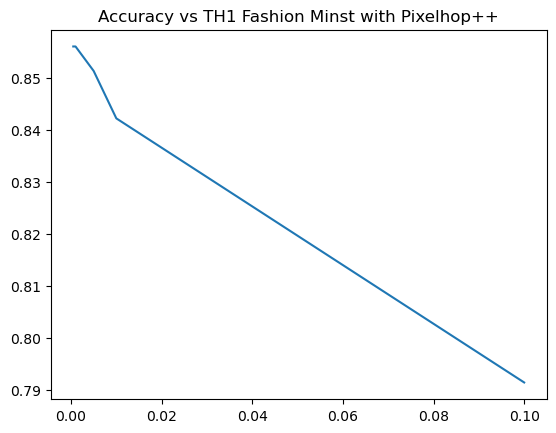

In [13]:
plt.plot(TH1_list, acc_list)
plt.title('Accuracy vs TH1 Fashion Minst with Pixelhop++')

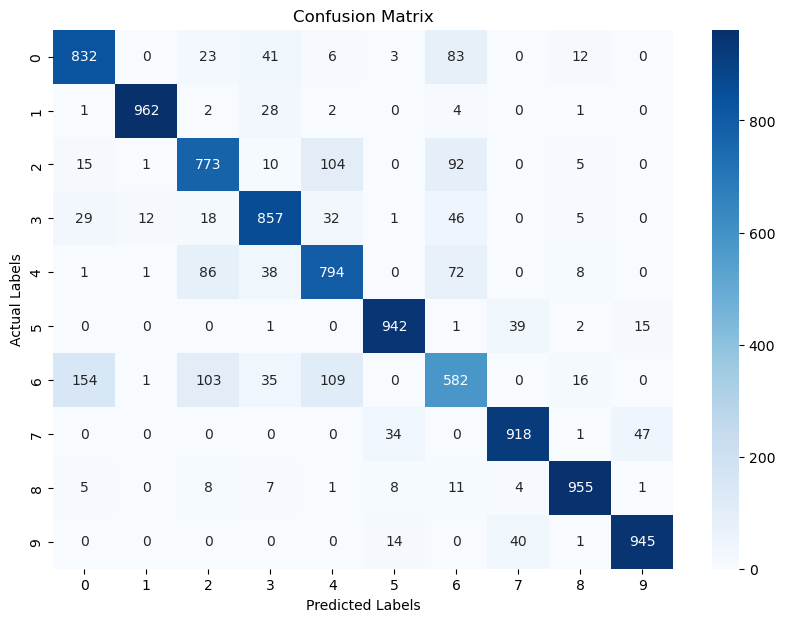

Confusion Matrix:
 [[832   0  23  41   6   3  83   0  12   0]
 [  1 962   2  28   2   0   4   0   1   0]
 [ 15   1 773  10 104   0  92   0   5   0]
 [ 29  12  18 857  32   1  46   0   5   0]
 [  1   1  86  38 794   0  72   0   8   0]
 [  0   0   0   1   0 942   1  39   2  15]
 [154   1 103  35 109   0 582   0  16   0]
 [  0   0   0   0   0  34   0 918   1  47]
 [  5   0   8   7   1   8  11   4 955   1]
 [  0   0   0   0   0  14   0  40   1 945]]


In [14]:
y_pred = clf.predict(np.squeeze(test_hop3_feats))

# Step 2: Compute the confusion matrix
cm = confusion_matrix(np.squeeze(y_test), y_pred)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Additional information, if needed:
print("Confusion Matrix:\n", cm)